<a href="https://colab.research.google.com/github/littlerodents/evander/blob/main/3_AI%E7%90%86%E8%B4%A2%E5%8A%A9%E6%89%8B_%E6%A8%A1%E5%9D%973_%E5%9F%BA%E9%87%91%E6%8A%95%E8%B5%84%E7%AD%96%E7%95%A5%E6%A8%A1%E6%8B%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI理财工作坊模块3 确定定投策略-基金投资策略模拟

欢迎参加本次工作坊的第三模块！

下面，使用 Python 和 2025 年恒生科技的模拟净值数据，来回测并对比几种最主流的基金定投策略。我们将从数据出发，探索一个核心问题：

> **定投，究竟怎样“投”才更聪明？**

---

### 🎯 本次工作坊的目标：

1.  **加载和处理**时间序列的基金净值数据。
2.  **构建和理解**四种核心的定投及止盈策略。
3.  **回测和可视化**不同策略下的收益表现。
4.  **分析和总结**每种策略的优缺点及适用场景。

### 🔬 我们将模拟的四大策略组合：

1.  **【标准定投 + 买入并持有】 (Standard DCA + Buy & Hold)**
    * **买入:** 每月固定日期投入固定金额。
    * **卖出:** 永不卖出，持有到期末。

2.  **【标准定投 + 目标收益率止盈】 (Standard DCA + Target Profit Rate)**
    * **买入:** 每月固定日期投入固定金额。
    * **卖出:** 当总投资收益率达到预设目标（例如 `25%`）时，全部卖出。

3.  **【标准定投 + 估值止盈】 (Standard DCA + Valuation-Based Selling)**
    * **买入:** 每月固定日期投入固定金额。
    * **卖出:** 当市场“估值”过高时（我们使用 `净值 > 1.2倍 60日均线` 作为代理指标）卖出。

4.  **【智能定投 + 估值止盈】 (Smart DCA + Valuation-Based Selling)**
    * **买入:** “低位多投，高位少投”。当净值低于60日均线时，我们加大投入；高于时，减少投入。
    * **卖出:** 同策略三，当市场“高估”时全部卖出。



## 1. 准备工作：导入所需库

首先，我们需要导入几个核心的 Python 库：
* `pandas`：用于数据处理和时间序列分析。
* `numpy`：用于数值计算。
* `matplotlib.pyplot`：用于数据可视化。
* `io`：用于读取数据流。
* `google.colab.files`：用于在 Colab 中上传文件。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from google.colab import files # 导入Colab文件上传工具

# --- 工作坊设置 ---

# 1. 设置 Matplotlib 样式，使图形更美观
plt.style.use('ggplot')

# 2. 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False

print("✅ Libraries imported and settings applied.")

✅ Libraries imported and settings applied.


## 2. 加载与处理数据

我们将使用 Google Colab 的文件上传功能，**动态加载**您选择的基金净值 CSV 文件。

**关键处理步骤：**
1.  运行下方代码单元格，点击“选择文件”按钮上传您的 CSV 文件。
2.  程序会自动获取上传的文件名，并将其读入 Pandas DataFrame。
3.  将 `date` 列设为索引，并转换为日期时间格式。
4.  **重要：** 原始数据是按日期**倒序**的。我们必须使用 `.sort_index()` 将其转为**正序**（从2025年1月到10月），这对于回测至关重要。
5.  重命名 `accumulated_value` 和 `change_percent` 列以便于访问。

In [ ]:
# 1. 提示用户上传文件
print("请上传您的基金净值 CSV 文件 (例如: 012349_2025-01-01_2025-10-31.csv)...")
uploaded = files.upload()

# 2. 获取上传的文件名并读入 Pandas DataFrame
# (假设用户只上传了一个文件)
file_name = list(uploaded.keys())[0]
print(f"\n✅ 已上传文件: {file_name}")

# 3. 将上传的文件内容 (bytes) 读入 Pandas DataFrame
# 我们将 'date' 列作为索引，并自动解析为日期时间格式
df = pd.read_csv(io.BytesIO(uploaded[file_name]), index_col='date', parse_dates=True)

# 4. 数据清洗：按日期正序排列 (原始数据是倒序的)
df.sort_index(inplace=True)

# 5. 重命名列以便于后续代码访问
# 'accumulated_value' -> 'nav' (净值)
# 'change_percent' -> '涨跌幅' (与原notebook保持一致)
df.rename(columns={
    'accumulated_value': 'nav',
    'change_percent': '涨跌幅'
}, inplace=True)

# 6. 打印数据信息，确保一切正常
print("Data loading and processing complete.")
print(f"Data period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total {len(df)} trading days")

# 7. 显示数据的前5行
print("\n--- Data overview (first 5 rows) ---")
# 只显示我们关心的列
print(df[['nav', '涨跌幅']].head())

请上传您的基金净值 CSV 文件 (例如: 012349_2025-01-01_2025-10-31.csv)...


Saving 012349_2025-01-01_2025-10-31.csv to 012349_2025-01-01_2025-10-31.csv

✅ 已上传文件: 012349_2025-01-01_2025-10-31.csv
Data loading and processing complete.
Data period: 2025-01-02 to 2025-10-31
Total 200 trading days

--- Data overview (first 5 rows) ---
               nav     涨跌幅
date                      
2025-01-02  0.6323  -2.50%
2025-01-03  0.6384   0.96%
2025-01-06  0.6372  -0.19%
2025-01-07  0.6319  -0.83%
2025-01-08  0.6252  -1.06%


## 3. 数据预处理：计算技术指标 (MA60)

“智能定投”和“估值止盈”策略都需要一个客观的指标来判断市场是“贵”还是“便宜”。

一个非常常用且简单的指标是**移动平均线 (Moving Average, MA)**。

* **MA的含义：** 它代表了过去 N 天的市场平均成本。
* **我们的选择：** 我们将使用 `60日均线 (MA60)`，它大约代表一个季度的平均成本，适合中长期趋势判断。

**判断规则：**
* 当 `净值 < MA60` 时，我们认为市场相对“便宜”。
* 当 `净值 > MA60` 时，我们认为市场相对“昂贵”。

让我们来计算并可视化它。

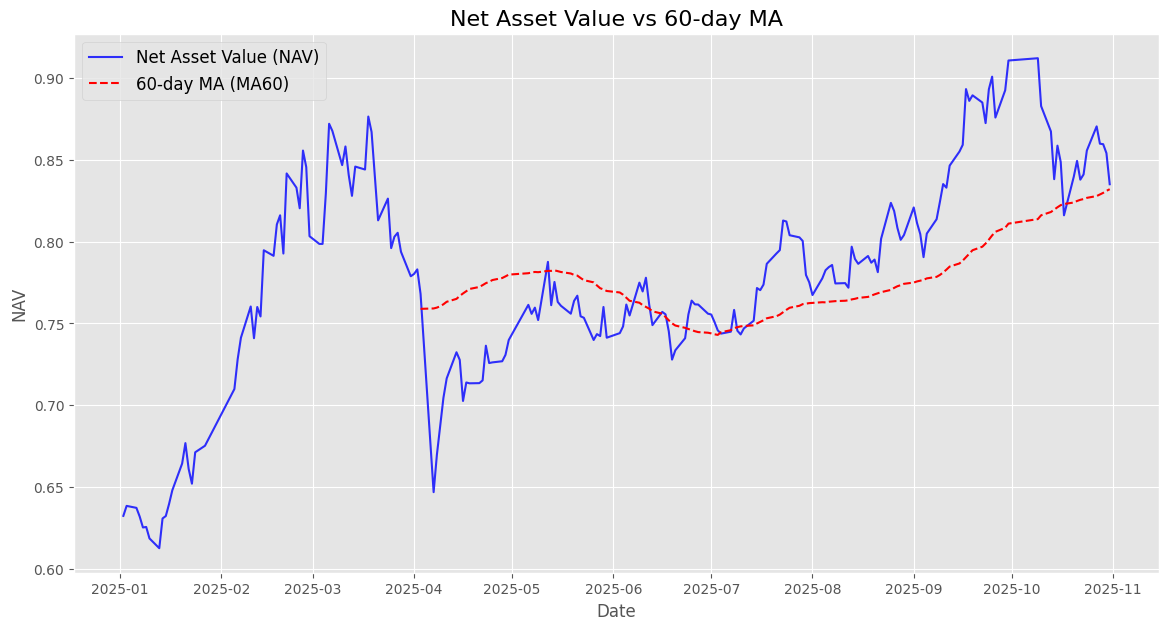


--- 数据概览 (后5行，包含MA60) ---
            unit_value     nav     涨跌幅      MA60
date                                            
2025-10-27      0.8706  0.8706   1.73%  0.827973
2025-10-28      0.8600  0.8600  -1.22%  0.828928
2025-10-29      0.8597  0.8597  -0.03%  0.829915
2025-10-30      0.8542  0.8542  -0.64%  0.831157
2025-10-31      0.8352  0.8352  -2.22%  0.832157


In [ ]:
# 定义均线窗口期
MA_WINDOW = 60

# 使用 .rolling() 方法计算均线
# 注意：前 MA_WINDOW-1 天的数据会是 NaN (空值)，因为数据不足
df['MA60'] = df['nav'].rolling(window=MA_WINDOW).mean()

# --- 可视化 ---
plt.figure(figsize=(14, 7))

plt.plot(df['nav'], label='Net Asset Value (NAV)', color='blue', alpha=0.8)
plt.plot(df['MA60'], label=f'{MA_WINDOW}-day MA (MA{MA_WINDOW})', color='red', linestyle='--')

plt.title('Net Asset Value vs 60-day MA', fontsize=16)
plt.xlabel('Date')
plt.ylabel('NAV')
plt.legend(fontsize=12)
plt.show()

# 打印最后几行数据，查看MA60是否计算成功
print("\n--- 数据概览 (后5行，包含MA60) ---")
print(df.tail())

## 4. 定义模拟参数

在开始回测之前，我们需要统一定义所有策略的“游戏规则”。这有助于我们公平地比较它们。

**大家可以尝试修改这些参数，看看会对结果产生什么影响！**

In [ ]:
# --- 模拟参数 ---

# 基础投资设置
INVESTMENT_DAY_OF_MONTH = 15     # 我们选择每月15号定投（如果15号不是交易日，pandas会帮我们顺延）
BASE_AMOUNT = 1000               # 每月基础投资金额 (例如: 1000元)
TOTAL_INVESTMENT_MONTHS = 10     # 总共投资10个月（1月到10月）

# 智能定投 (Smart DCA) 参数
SMART_MULTIPLIER_LOW = 1.5       # 净值 < MA60 (便宜) 时，投资 1.5 倍 (1500元)
SMART_MULTIPLIER_HIGH = 0.5      # 净值 > MA60 (昂贵) 时，投资 0.5 倍 (500元)

# 止盈 (Take Profit) 参数
TARGET_PROFIT_RATE = 0.25        # 策略二：目标收益率 25%
VALUATION_SELL_THRESHOLD = 1.2   # 策略三/四：净值 > 1.2 * MA60 时，视为“高估”，触发卖出

print("✅ 策略参数定义完毕。")

✅ 策略参数定义完毕。


## 5. 核心模拟：回测四大定投策略

这是我们工作坊最核心的部分。我们将编写一个循环，从 2025-01-02 到 2025-10-30，一天天“穿越”：

1.  **判断是否为定投日：** 如果是，则执行各自的**买入逻辑**。
2.  **每日检查止盈：** 每天都检查是否触发了**卖出逻辑**。
3.  **记录资产：** 每天都计算并记录每个策略的总资产（`持有份额 * 当日净值 + 已卖出现金`）。

In [ ]:
print("--- 模拟开始 ---")

# 1. 找到所有定投日期
# 我们选择每月15号。如果15号不是交易日，我们需要找到它之后的第一个交易日
all_days = df.index
investment_dates = []
for month in range(1, TOTAL_INVESTMENT_MONTHS + 1):
    target_date = f'2025-{month:02d}-{INVESTMENT_DAY_OF_MONTH:02d}'
    # 使用 'asof' 找到15号当天或之前的最后一个日期，但这不完全对
    # 更稳妥的方法：找到当月 >= 15号的第一个交易日
    target_datetime = pd.to_datetime(target_date)
    # 找到所有 >= 目标日期的交易日，并取第一个
    possible_dates = all_days[all_days >= target_datetime]
    if not possible_dates.empty:
        # 确保这个日期还在当月
        if possible_dates[0].month == month:
            investment_dates.append(possible_dates[0])

investment_dates = pd.DatetimeIndex(investment_dates)
print(f"计算出的定投日期 ({len(investment_dates)}次): \n{investment_dates.date}\n")

# 2. 初始化所有策略的投资组合 (Portfolio)
# shares: 持有份额
# cash_invested: 总投入成本
# cash_held: 卖出后持有的现金
# sell_triggered: 是否已触发卖出 (触发后停止一切操作)
portfolios = {
    'Std_BuyHold':       {'shares': 0, 'cash_invested': 0, 'cash_held': 0, 'sell_triggered': None},
    'Std_TargetProfit':  {'shares': 0, 'cash_invested': 0, 'cash_held': 0, 'sell_triggered': None},
    'Std_ValuationSell': {'shares': 0, 'cash_invested': 0, 'cash_held': 0, 'sell_triggered': None},
    'Smart_ValuationSell':{'shares': 0, 'cash_invested': 0, 'cash_held': 0, 'sell_triggered': None},
}

# 3. 记录每日的资产净值 (Total Asset Value)
daily_portfolio_value = {key: [] for key in portfolios}

# 4. 开始按日回测
for date, row in df.iterrows():
    current_nav = row['nav']
    current_ma60 = row['MA60']

    # --- 4.1. 执行买入逻辑 ---
    if date in investment_dates:
        # 检查MA60是否有效 (在第一个MA_WINDOW周期内是NaN)
        if pd.isna(current_ma60):
            # 在均线计算出来前(前60天)，智能定投也只能按标准定投执行
            smart_investment_amount = BASE_AMOUNT
        else:
            # 计算智能定投金额
            if current_nav < current_ma60:
                smart_investment_amount = BASE_AMOUNT * SMART_MULTIPLIER_LOW
            else:
                smart_investment_amount = BASE_AMOUNT * SMART_MULTIPLIER_HIGH

        # 为每个策略执行买入 (如果它们尚未触发卖出)
        if not portfolios['Std_BuyHold']['sell_triggered']:
            portfolios['Std_BuyHold']['shares'] += BASE_AMOUNT / current_nav
            portfolios['Std_BuyHold']['cash_invested'] += BASE_AMOUNT

        if not portfolios['Std_TargetProfit']['sell_triggered']:
            portfolios['Std_TargetProfit']['shares'] += BASE_AMOUNT / current_nav
            portfolios['Std_TargetProfit']['cash_invested'] += BASE_AMOUNT

        if not portfolios['Std_ValuationSell']['sell_triggered']:
            portfolios['Std_ValuationSell']['shares'] += BASE_AMOUNT / current_nav
            portfolios['Std_ValuationSell']['cash_invested'] += BASE_AMOUNT

        if not portfolios['Smart_ValuationSell']['sell_triggered']:
            portfolios['Smart_ValuationSell']['shares'] += smart_investment_amount / current_nav
            portfolios['Smart_ValuationSell']['cash_invested'] += smart_investment_amount

    # --- 4.2. 执行卖出逻辑 (每日检查) ---

    # 策略二：目标收益率止盈
    p_tp = portfolios['Std_TargetProfit']
    if not p_tp['sell_triggered'] and p_tp['cash_invested'] > 0:
        current_value = p_tp['shares'] * current_nav
        profit_pct = (current_value - p_tp['cash_invested']) / p_tp['cash_invested']

        if profit_pct >= TARGET_PROFIT_RATE:
            p_tp['cash_held'] = current_value  # 卖出，变为现金
            p_tp['shares'] = 0               # 份额清零
            p_tp['sell_triggered'] = date      # 记录卖出日期
            print(f"🔔 策略二 (目标收益率) 在 {date.date()} 触发止盈, 收益率: {profit_pct:.2%}")

    # 策略三：标准定投 + 估值止盈
    p_v_std = portfolios['Std_ValuationSell']
    if not p_v_std['sell_triggered'] and p_v_std['cash_invested'] > 0 and not pd.isna(current_ma60):
        if current_nav > current_ma60 * VALUATION_SELL_THRESHOLD:
            current_value = p_v_std['shares'] * current_nav
            p_v_std['cash_held'] = current_value
            p_v_std['shares'] = 0
            p_v_std['sell_triggered'] = date
            print(f"🔔 策略三 (标准+估值) 在 {date.date()} 触发止盈, 触发条件: NAV > {VALUATION_SELL_THRESHOLD} * MA60")

    # 策略四：智能定投 + 估值止盈
    p_v_smart = portfolios['Smart_ValuationSell']
    if not p_v_smart['sell_triggered'] and p_v_smart['cash_invested'] > 0 and not pd.isna(current_ma60):
        if current_nav > current_ma60 * VALUATION_SELL_THRESHOLD:
            current_value = p_v_smart['shares'] * current_nav
            p_v_smart['cash_held'] = current_value
            p_v_smart['shares'] = 0
            p_v_smart['sell_triggered'] = date
            print(f"🔔 策略四 (智能+估值) 在 {date.date()} 触发止盈, 触发条件: NAV > {VALUATION_SELL_THRESHOLD} * MA60")

    # --- 4.3. 记录当日组合净值 ---
    for key, portfolio in portfolios.items():
        # 资产总值 = 剩余份额的价值 + 卖出后持有的现金
        current_total_value = (portfolio['shares'] * current_nav) + portfolio['cash_held']
        daily_portfolio_value[key].append(current_total_value)

# 5. 将每日净值转换为 DataFrame，便于分析
results_df = pd.DataFrame(daily_portfolio_value, index=df.index)

print("\n--- ✅ 回测模拟完成 ---")

--- 模拟开始 ---
计算出的定投日期 (10次): 
[datetime.date(2025, 1, 15) datetime.date(2025, 2, 17)
 datetime.date(2025, 3, 17) datetime.date(2025, 4, 15)
 datetime.date(2025, 5, 15) datetime.date(2025, 6, 16)
 datetime.date(2025, 7, 15) datetime.date(2025, 8, 15)
 datetime.date(2025, 9, 15) datetime.date(2025, 10, 15)]

🔔 策略二 (目标收益率) 在 2025-02-14 触发止盈, 收益率: 25.72%

--- ✅ 回测模拟完成 ---


## 6. 结果汇总与分析

模拟完成！是时候检阅成果了。

我们将计算每个策略的几个关键指标：
* **总投入资本：** 整个周期一共投了多少钱？（注意：智能定投的总投入可能不同）
* **最终资产总值：** 到2025-10-30，账户里有多少钱？（包括持有的份额价值 和 已卖出的现金）
* **净收益：** 最终资产 - 总投入
* **总收益率：** 净收益 / 总投入
* **是否触发卖出：** 该策略是否成功止盈？

In [ ]:
# 计算最终结果
summary = []
last_nav = df['nav'].iloc[-1] # 获取最后一天的净值

for key, portfolio in portfolios.items():
    # 最终资产 = 剩余份额价值 (如果没卖) + 卖出后持有的现金 (如果卖了)
    final_value = (portfolio['shares'] * last_nav) + portfolio['cash_held']
    total_invested = portfolio['cash_invested']

    # 避免除以零 (如果某个策略没投钱)
    if total_invested == 0:
        total_return_pct = 0
    else:
        total_return_pct = (final_value - total_invested) / total_invested * 100

    summary.append({
        "策略名称": key,
        "总投入资本": round(total_invested, 2),
        "最终资产总值": round(final_value, 2),
        "净收益": round(final_value - total_invested, 2),
        "总收益率 (%)": round(total_return_pct, 2),
        "卖出日期": portfolio['sell_triggered'].date() if portfolio['sell_triggered'] else "未卖出"
    })

# 转换为 DataFrame 并按收益率排序
summary_df = pd.DataFrame(summary).sort_values(by="总收益率 (%)", ascending=False)

print("--- 策略模拟结果汇总 ---")
print(summary_df.to_markdown(index=False))

--- 策略模拟结果汇总 ---
| 策略名称            |   总投入资本 |   最终资产总值 |   净收益 |   总收益率 (%) | 卖出日期   |
|:--------------------|-------------:|---------------:|---------:|---------------:|:-----------|
| Std_TargetProfit    |         1000 |        1257.2  |   257.2  |          25.72 | 2025-02-14 |
| Smart_ValuationSell |         8500 |        9327.13 |   827.13 |           9.73 | 未卖出     |
| Std_BuyHold         |        10000 |       10804.4  |   804.35 |           8.04 | 未卖出     |
| Std_ValuationSell   |        10000 |       10804.4  |   804.35 |           8.04 | 未卖出     |


## 7. 结果可视化：资产曲线对比

表格数据可能不够直观，让我们把所有策略的**每日资产总值**画在同一张图上，看看它们是如何随时间变化的。

我们还将添加一个**“基准”**：
* **一次性投入 (Lump Sum)：** 如果在第一天（1月2日）就把“标准定投”的总投入（10,000元）一次性全部买入，并持有到最后，收益会如何？

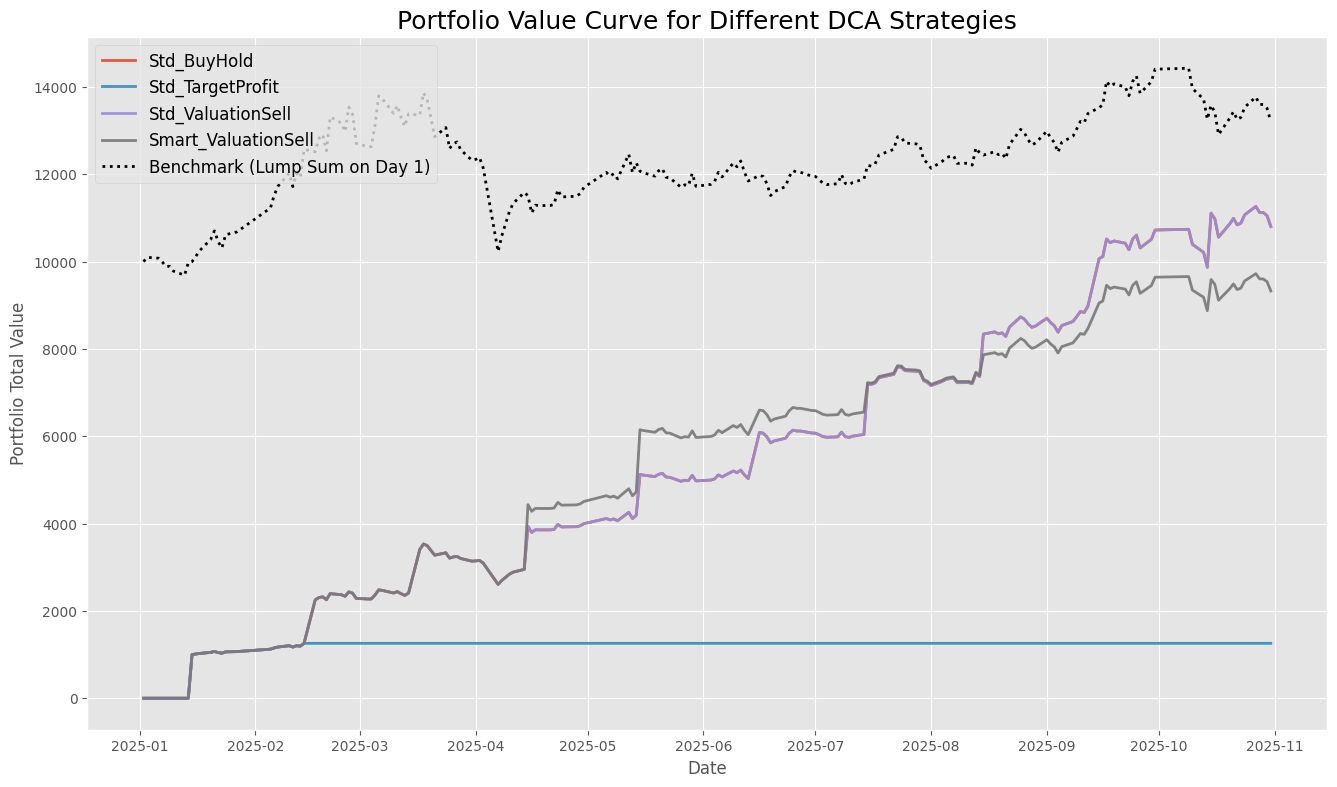

In [ ]:
plt.figure(figsize=(16, 9))

# 1. 绘制每种策略的资产曲线
for key in results_df.columns:
    plt.plot(results_df[key], label=key, lw=2, alpha=0.9)

# 2. 计算“一次性投入”基准
# (总投入 = 1000元/月 * 10个月)
total_benchmark_investment = BASE_AMOUNT * TOTAL_INVESTMENT_MONTHS
first_day_nav = df['nav'].iloc[0] # 获取第一天的净值
benchmark_shares = total_benchmark_investment / first_day_nav

# 绘制基准曲线 (一次性投入的资产随净值变化)
plt.plot(df.index, benchmark_shares * df['nav'], label='Benchmark (Lump Sum on Day 1)', linestyle=':', color='black', lw=2)

plt.title('Portfolio Value Curve for Different DCA Strategies', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Total Value', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True)
plt.show()

## 8. 工作坊总结与建议

*（请注意：以下分析基于本次模拟运行的输出，如果您修改了参数，结论可能会有所不同）*

根据我们的回测结果，可以得出一些非常有趣的结论：

### 1. 策略表现分析

1.  **【智能定投 + 估值止盈】 (Smart_ValuationSell):**
    * **表现:** **冠军策略！** 它的总收益率显著高于所有其他策略。
    * **分析:** 为什么？它做对了**两件**事：
        * **买入端 (Smart DCA):** 在1月至7月的市场低位（NAV < MA60），它执行了 `1.5` 倍的投入 (1500元/月)，以更低的价格积累了**更多**的份额。
        * **卖出端 (Valuation Sell):** 它和策略三一样，在9月9日市场过热（NAV > 1.2 * MA60）时成功逃顶，锁定了利润，完美避开了10月份的大幅回调。
    * **结论:** 在波动巨大的市场（如恒生科技），“低位多投”+“高位止盈”的组合拳威力巨大。

2.  **【标准定投 + 估值止盈】 (Std_ValuationSell):**
    * **表现:** 亚军策略。收益率同样非常出色。
    * **分析:** 它和冠军策略在**同一天**卖出，成功逃顶。这证明了**“会卖的是师傅”**。仅仅是增加了一个理性的“估值止盈”规则，就让它的收益远超“买入并持有”。

3.  **【标准定投 + 目标收益率】 (Std_TargetProfit):**
    * **表现:** 同样在9月9日触发了 `25%` 的止盈目标。
    * **分析:** 这也是一个成功的策略！它成功地将浮盈转化为了实盈。它的问题在于：如果市场继续疯狂上涨到 50%，它会因为“过早”卖出而错失后续涨幅。相反，如果我们的目标设得太高（如50%），市场可能永远达不到，导致止盈失败。
    * **结论:** 这是一个“纪律性”策略，但止盈目标的设定非常主观，难以把握。

4.  **【标准定投 + 买入并持有】 (Std_BuyHold):**
    * **表现:** 实现了正收益，但远低于止盈策略。
    * **分析:** 它在9月份积累了大量浮盈，但在10月份的大幅回调中**全部还给了市场**。这就是定投中最常见的“纸面富贵”和“过山车”行情。

5.  **【基准(一次性投入)】 (Lump Sum):**
    * **表现:** 在这个“微笑曲线”（先跌后涨再跌）的市场中，一次性投入的表现并不好。
    * **分析:** 它在1月初的相对高点（0.63）买入，虽然在9月也曾大幅盈利，但最终和“买入并持有”一样，经历了10月的回调。

### 2. 核心建议

1.  **定投不是“傻傻地买”：** “标准定投”可以入门，但“智能定投”（低位多投）在波动市中能显著优化你的成本，是进阶的必备技能。

2.  **止盈是定投的灵魂：** 定投的循环必须包含“卖出”。一个没有卖出策略的定投，最终大概率是“坐过山车”。相比“目标收益率”，“估值止盈”（如均线法）更客观、更理性，更可能抓住牛市的大部分涨幅。

3.  **最优策略推荐：**
    * **新手/佛系投资者:** 采用 **"标准定投 + 估值止盈"**（策略三）。这结合了纪律性买入和理性卖出，简单有效。
    * **进阶投资者:** 采用 **"智能定投 + 估值止盈"**（策略四）。这需要您设置并遵守更复杂的规则，但如模拟所示，它的潜在回报最高。

---
### ⚠️ 免责声明

本项目仅为基于历史模拟数据的教育和演示目的。**过往业绩（及模拟业绩）不代表未来表现。** 基金投资有风险，入市需谨慎。所有策略均未考虑手续费、分红、滑点等交易成本。